# Testeo del banco de PLLs
### Prueba del módulo `plllib_v7`

La diferencias con `plllib_v6` son:
  - Agregamos la nueva feature zcross que detecta los cruces por cero (de pendiente positiva) del vco
  
  

## Diagrama del PLL
![](f1.png)

In [1]:
%matplotlib widget

import torch
import numpy as np
from math import *
from scipy import signal as sig
from speechbrain.processing.signal_processing import convolve1d
from torchaudio import transforms
from matplotlib import pyplot as plt 
from speechbrain.dataio.dataio import read_audio    
import time
from plllib_v7 import PLLBank
# from pll import pll_signal


wavi = read_audio('sa1.wav')
l = wavi.shape[0]
bs = 1
wav = torch.zeros((bs,l))
for i in range(bs):
    wav[i] = read_audio('sa1.wav')

params = {'Fs':16000, 'n_channels':60, 'fpmin':50, 'fpmax':6000, 'gain': 0.1,
           'agcgain':1, 'loudness':True, 'show_all':False}


# Procesamiento
# Normalización
wav = (wav - wav.mean())/wav.std()
# norm = True
# Filtro de pre-enfasis
# wav[1:] = wav[1:] - 0.97*wav[:-1]
# pe = False
# Ganancia
# wav *= gain

pllbank = PLLBank(params)

pllout, fp = pllbank(wav)

torchvision is not available - cannot save figures


[Text(0.5, 1.0, 'Cruces por cero Versión: 7'), Text(0, 0.5, 'Hz')]

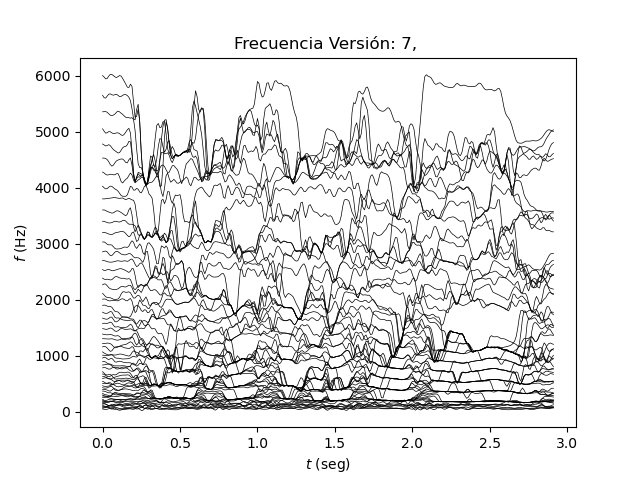

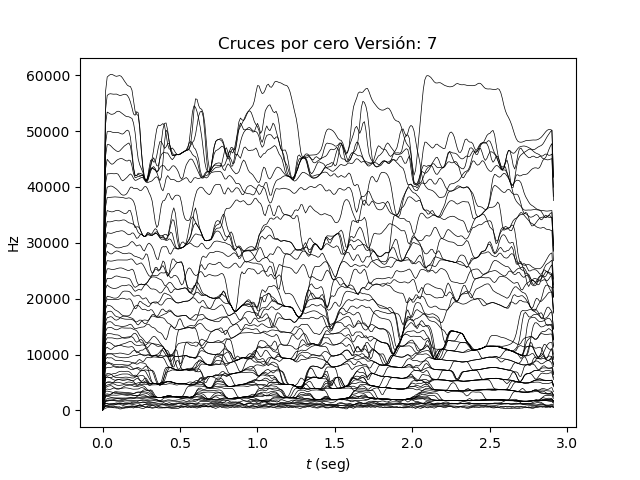

In [2]:
N = 2048
Fs = params['Fs']
n_channels = params['n_channels']
ts = pllbank.ts*1e-3
tm = (np.arange(pllout.shape[1]))*ts

fig,ax = plt.subplots(1,1)
ax.set(xlabel='$t$ (seg)')

ax.set(title = "Frecuencia Versión: 7, ",ylabel='$f$ (Hz)')
# pxx,frecs, bins, im = ax.specgram(wav[0], NFFT=N, Fs=Fs, cmap= None, mode='psd')
# _ = ax.set_ylim(0,Fs/2)
for i in range(n_channels):
    _ = ax.plot(tm,pllout[0,:,i,1].cpu(),'k',lw=0.5)

fig,bx = plt.subplots(1,1)
bx.set(xlabel='$t$ (seg)')
for i in range(n_channels):
    _ = bx.plot(tm,pllout[0,:,i,2].cpu(),'k',lw=0.5)
bx.set(title = "Cruces por cero Versión: 7",ylabel='Hz')

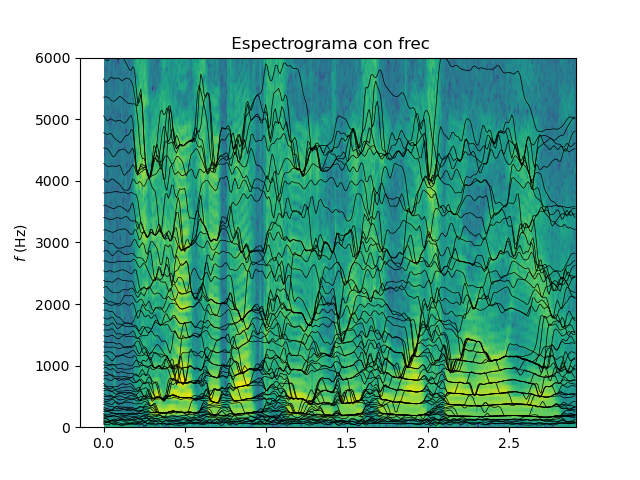

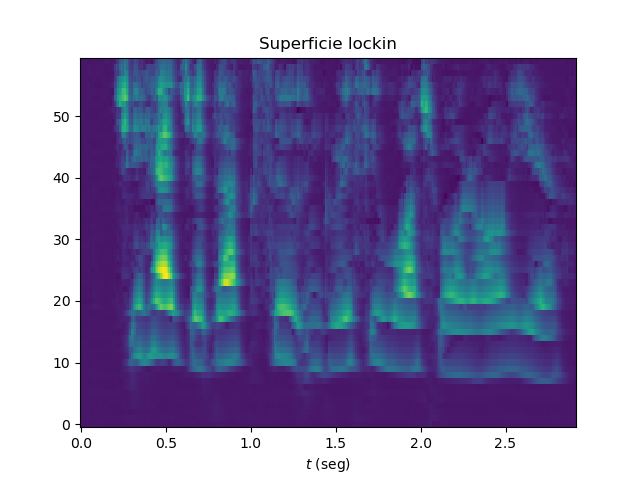

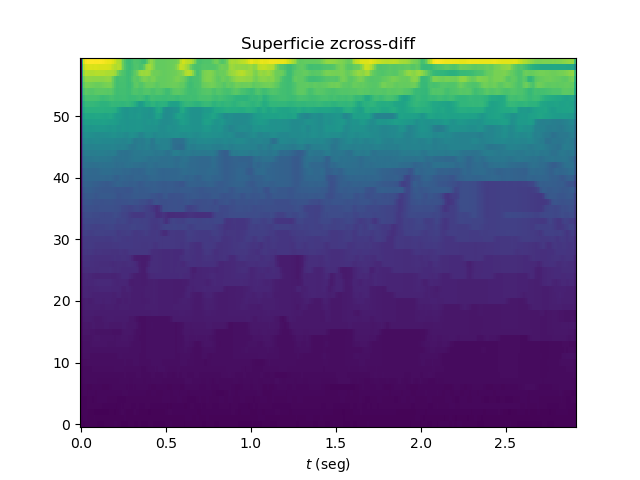

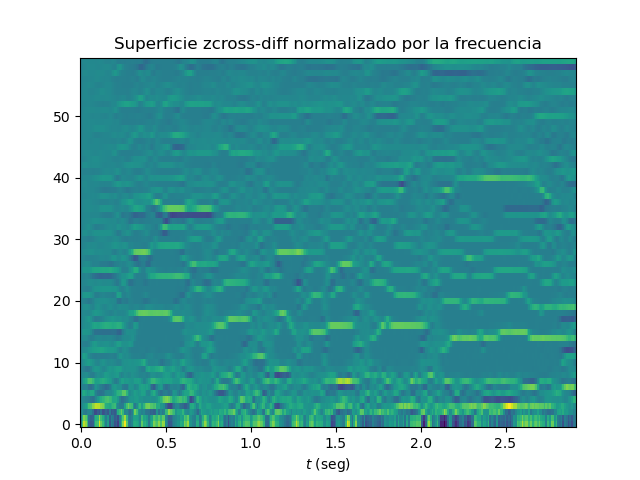

In [3]:
# Las 4 salidas

# Espectrograma
fig,ax = plt.subplots(1,1)
ax.set(title = " Espectrograma con frec",ylabel='$f$ (Hz)')
pxx,frecs, bins, im = ax.specgram(wav[0], Fs=Fs, cmap= None, mode='psd')
_ = ax.set_ylim(0,6000)
_ = ax.plot(tm,pllout[0,:,:,1].cpu(),'k',lw=0.5)

# Superficie lock-in
fig,bx = plt.subplots(1,1)
tspec,fspec = np.meshgrid(tm,np.arange(n_channels))
bx.set(title='Superficie lockin', xlabel='$t$ (seg)')
_ = bx.pcolormesh(tspec,fspec,pllout[0,:,:,0].cpu().T,shading='auto')

# Superficie differencias del zcross
fig,cx = plt.subplots(1,1)
# tspec,fspec = np.meshgrid(tm,np.arange(n_channels))
cx.set(title='Superficie zcross-diff', xlabel='$t$ (seg)')
_ = cx.pcolormesh(tspec,fspec,pllout[0,:,:,2].cpu().T,shading='auto')

# Superficie differencias del zcross
fig,dx = plt.subplots(1,1)
# tspec,fspec = np.meshgrid(tm,np.arange(n_channels))
dx.set(title='Superficie zcross-diff normalizado por la frecuencia', xlabel='$t$ (seg)')
_ = dx.pcolormesh(tspec,fspec,pllout[0,:,:,3].cpu().T,shading='auto')


### Para generar la librería pll:

Se escribe un [setup.py](./setup.py), que lo que hace es pedir que cythonize el [pll.pyx](./pll.pyx), que es la librería de pll escrita en cython (según mi leal saber y entender, sobre todo esto último). También busca la verdadera librería de numpy, porque si no, no la encuentra. 

Luego se corre esta instrucción que generará un archivo [pll.c](./pll.c), imposible de comprender, y lo compila como un `.so`:

> python setup.py build_ext --inplace

Luego, cuando uno lo llama, simplemente tiene que llamar a la librería como `pll`, e importar las funciones que definió adentro, en este caso, `pll_signal`

**Nota:** en este esquema `pll_signal` es una función externa cuando la escribo en C. Pero para la clase `PLLBank` escrita en python completamente, es un método de la clase. Así que cuando se usa en la función `forward` de la clase, en el caso de la función de c, hay que llamarla sin ``pllbank``

**Nota2:** La librería de `numpy` la necesita para generar los arrays de elementos. No uso funciones de la librería, sino las versiones en C, pero sí la estructura `ndarray`. 